PROBLEM NEDİR?

Abdominal çoklu organ segmentasyonu, karın bölgesindeki çeşitli organların tıbbi görüntüler (BT ve MR) üzerinde belirlenmesi ve her organın sınırlarının doğru bir şekilde ayrılması işlemidir. Bu segmentasyon, her organın konumunu ve şeklini tespit ederek görüntü üzerinde voksel düzeyinde anotasyonlar yapmayı içerir.

PROBLEM FOTOĞRAFI

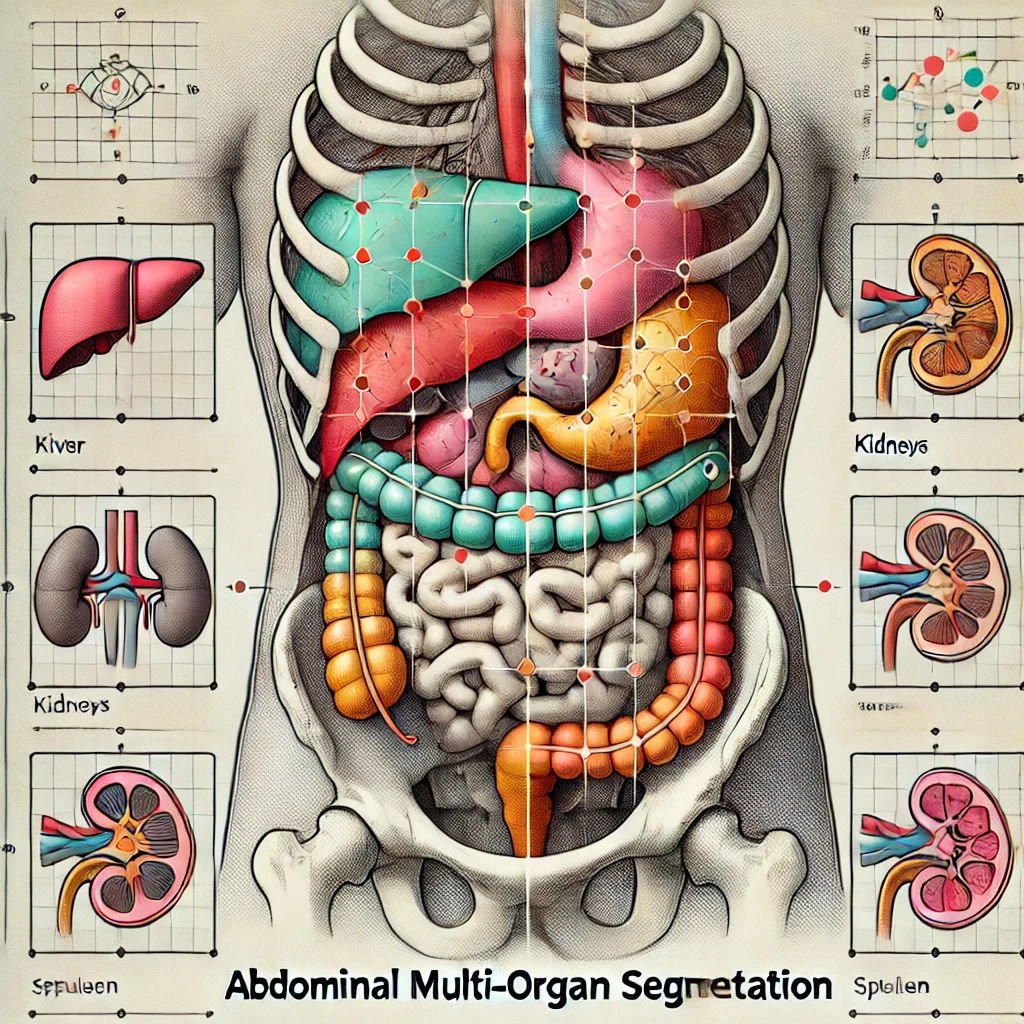

VERİ HAKKINDA

Bu projede kullanılan veri kümesi, karın bölgesindeki çoklu organların segmentasyonu için 500 BT (bilgisayarlı tomografi) ve 100 MR (manyetik rezonans) taramasından oluşmaktadır. Bu taramalar, Longgang Bölge Merkez Hastanesi ve Longgang Bölge Halk Hastanesi'nden retrospektif olarak toplanmıştır. BT ve MR veri tabanları farklı hastalara ait olup, aralarında herhangi bir ilişki yoktur (aynı hastadan alınmış ve eşleştirilmiş değildir).

Veri Kümesinin Özellikleri:

Organlar: Her tarama, 15 organın anotasyonlarını içermektedir. Bu organlar şunlardır: dalak, sağ böbrek, sol böbrek, safra kesesi, yemek borusu, karaciğer, mide, aort, inferior vena kava, pankreas, sağ adrenal bez, sol adrenal bez, duodenum, mesane, prostat/rahim. Ancak bazı veri noktalarında, organların eksik olması mümkündür (örneğin, cerrahi olarak çıkarılmış organlar ya da vücudun taranmayan kısımları). Format: Görüntüler DICOM formatında alınmış ve daha sonra yaygın olarak kullanılan tıbbi görüntü işleme formatı olan NIfTI'ye dönüştürülmüştür. Kapsam: Veriler, çok merkezli, çoklu üretici, çoklu modalite, çoklu faz ve çoklu hastalık durumlarına sahip hastalardan toplanmıştır. Bu çeşitlilik, verinin genelleştirilebilirliğini artırır.

img1 ve label1

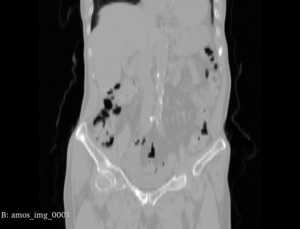

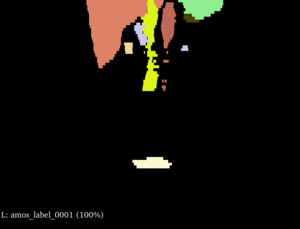

img2 ve label2

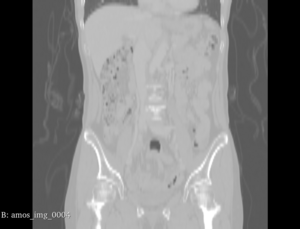

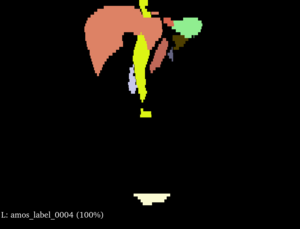

img3 ve label3

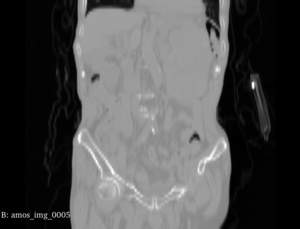

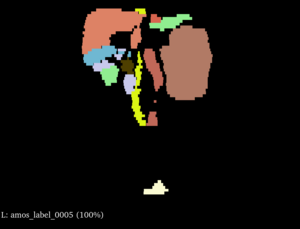

KÜTÜPHANELERİ İMPORT ET

In [ ]:
pip install monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 26.5 MB/s eta 0:00:00


Verileri colaba taşımak

In [ ]:
!wget 'https://zenodo.org/records/7155725/files/amos22.zip?download=1' -O amos22.zip

--2024-11-14 08:15:42--  https://zenodo.org/records/7155725/files/amos22.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.184.98.238, 188.185.79.172, 188.184.103.159, ...
Connecting to zenodo.org (zenodo.org)|188.184.98.238|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24234336519 (23G) [application/octet-stream]
Saving to: ‘amos22.zip’

amos22.zip          100%[===================>]  22.57G  17.6MB/s    in 22m 42s 

2024-11-14 08:38:24 (17.0 MB/s) - ‘amos22.zip’ saved [24234336519/24234336519]



In [ ]:
!unzip amos22.zip

Archive:  amos22.zip
   creating: amos22/
  inflating: amos22/.DS_Store        
  inflating: __MACOSX/amos22/._.DS_Store  
   creating: amos22/labelsTr/
   creating: amos22/labelsTs/
   creating: amos22/imagesTr/
  inflating: __MACOSX/amos22/._imagesTr  
   creating: amos22/imagesTs/
  inflating: amos22/readme.md        
  inflating: __MACOSX/amos22/._readme.md  
   creating: amos22/imagesVa/
  inflating: __MACOSX/amos22/._imagesVa  
   creating: amos22/labelsVa/
  inflating: amos22/dataset.json     
  inflating: amos22/labelsTr/amos_0001.nii.gz  
  inflating: amos22/labelsTr/amos_0584.nii.gz  
  inflating: amos22/labelsTr/amos_0162.nii.gz  
  inflating: amos22/labelsTr/amos_0588.nii.gz  
  inflating: amos22/labelsTr/amos_0113.nii.gz  
  inflating: amos22/labelsTr/amos_0170.nii.gz  
  inflating: amos22/labelsTr/amos_0596.nii.gz  
  inflating: amos22/labelsTr/amos_0158.nii.gz  
  inflating: amos22/labelsTr/amos_0058.nii.gz  
  inflating: amos22/labelsTr/amos_0392.nii.gz  
  inflating: a

In [ ]:
# MONAI ve PyTorch ile çalışmak için gerekli kütüphaneleri yükleyin
import os
import glob
import torch
from monai.data import Dataset, DataLoader, CacheDataset
from monai.transforms import (
    LoadImaged, EnsureChannelFirstd, Spacingd, Orientationd, ScaleIntensityRanged,
    CropForegroundd, RandCropByPosNegLabeld, RandFlipd, RandRotate90d,
    RandScaleIntensityd, RandShiftIntensityd, ToTensord
)
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
from monai.transforms import Compose
from monai.utils import set_determinism
import numpy as np
from tqdm import tqdm


In [ ]:
import nibabel as nib
import numpy as np
import os

# Organ ID değeri
target_organ_id = 7

# Etiketlerin bulunduğu dizin (labelTr dizini)
label_dir = "/content/amos22/labelsTr"  # labelTr dizin yolunu buraya yazın
output_dir = "path/to/processed_labels"  # Güncellenmiş etiketlerin kaydedileceği dizin

os.makedirs(output_dir, exist_ok=True)

for label_file in os.listdir(label_dir):
    # Label dosyasını yükleme
    label_path = os.path.join(label_dir, label_file)
    label_img = nib.load(label_path)
    label_data = label_img.get_fdata()

    # Sadece mideyi tutma (diğer organları sıfırla)
    label_data = (label_data == target_organ_id).astype(np.uint8)

    # Güncellenmiş etiket verisini kaydetme
    processed_label_img = nib.Nifti1Image(label_data, label_img.affine, label_img.header)
    output_path = os.path.join(output_dir, label_file)
    nib.save(processed_label_img, output_path)

    print(f"Güncellenmiş etiket dosyası kaydedildi: {output_path}")


Güncellenmiş etiket dosyası kaydedildi: path/to/processed_labels/amos_0197.nii.gz
Güncellenmiş etiket dosyası kaydedildi: path/to/processed_labels/amos_0027.nii.gz
Güncellenmiş etiket dosyası kaydedildi: path/to/processed_labels/amos_0141.nii.gz
Güncellenmiş etiket dosyası kaydedildi: path/to/processed_labels/amos_0083.nii.gz
Güncellenmiş etiket dosyası kaydedildi: path/to/processed_labels/amos_0135.nii.gz
Güncellenmiş etiket dosyası kaydedildi: path/to/processed_labels/amos_0033.nii.gz
Güncellenmiş etiket dosyası kaydedildi: path/to/processed_labels/amos_0111.nii.gz
Güncellenmiş etiket dosyası kaydedildi: path/to/processed_labels/amos_0272.nii.gz
Güncellenmiş etiket dosyası kaydedildi: path/to/processed_labels/amos_0156.nii.gz
Güncellenmiş etiket dosyası kaydedildi: path/to/processed_labels/amos_0514.nii.gz
Güncellenmiş etiket dosyası kaydedildi: path/to/processed_labels/amos_0127.nii.gz
Güncellenmiş etiket dosyası kaydedildi: path/to/processed_labels/amos_0391.nii.gz
Güncellenmiş eti

In [1]:
import torch
from monai.transforms import (
    LoadImageD, EnsureChannelFirstD, ScaleIntensityD, RandCropByPosNegLabelD,
    RandRotateD, RandFlipD, ToTensorD, ResizeD
)
from monai.data import DataLoader, Dataset, CacheDataset
from monai.networks.nets import UNet
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from torch.optim import Adam
import os

# Veri kümesi yolları
images_dir = "/content/amos22/imagesTr"  # imagesTr dizininin tam yolunu buraya yazın
labels_dir = "path/to/processed_labels"  # labelsTr dizininin tam yolunu buraya yazın

# Dizinlerdeki dosyaları listeleme
image_files = sorted([os.path.join(images_dir, f) for f in os.listdir(images_dir) if not f.startswith('.')])  # .DS_Store gibi nokta ile başlayan dosyaları filtrele
label_files = sorted([os.path.join(labels_dir, f) for f in os.listdir(labels_dir) if not f.startswith('.')])  # .DS_Store gibi nokta ile başlayan dosyaları filtrele

# DataLoader için dictionary listesi oluşturma
data_dicts = [{"image": img, "label": lbl} for img, lbl in zip(image_files, label_files)]

# Dönüşümler
train_transforms = [
    LoadImageD(keys=["image", "label"]),
    EnsureChannelFirstD(keys=["image", "label"]),
    ScaleIntensityD(keys=["image"]),
    ResizeD(keys=["image", "label"], spatial_size=(96, 96, 96), mode=['trilinear', 'nearest']),  # Tutarlılık için yeniden boyutlandırma
    RandCropByPosNegLabelD(keys=["image", "label"], label_key="label", spatial_size=(64, 64, 64), pos=1, neg=1, num_samples=4),
    RandFlipD(keys=["image", "label"], spatial_axis=[0], prob=0.5),
    ToTensorD(keys=["image", "label"]),
]

val_transforms = [
    LoadImageD(keys=["image", "label"]),
    EnsureChannelFirstD(keys=["image", "label"]),
    ScaleIntensityD(keys=["image"]),
    ToTensorD(keys=["image", "label"]),
]



In [2]:
# Veri yükleyiciler
train_ds = CacheDataset(data=data_dicts, transform=train_transforms, cache_rate=0.5)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=4)

val_ds = CacheDataset(data=data_dicts, transform=val_transforms, cache_rate=0.5)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4)


Loading dataset: 100%|██████████| 120/120 [03:29<00:00,  1.75s/it]


In [3]:
# Model, Loss ve Optimizer Tanımı
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    channels=(8, 16, 32, 64, 128),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)
loss_function = DiceLoss(sigmoid=True)
optimizer = Adam(model.parameters(), lr=1e-4)

In [4]:
# Eğitim Parametreleri
max_epochs = 10
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
dice_metric = DiceMetric(include_background=False, reduction="mean")

# Eğitim Döngüsü
for epoch in range(max_epochs):
    print(f"Epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device)

        # Model eğitimi
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"Epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    # Doğrulama
    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_images, val_labels = val_data["image"].to(device), val_data["label"].to(device)
                val_outputs = sliding_window_inference(val_images, (64, 64, 64), 4, model)
                dice_metric(y_pred=val_outputs, y=val_labels)
            metric = dice_metric.aggregate().item()
            dice_metric.reset()
            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), "model.pth")
                print("saved new best metric model")
            print(f"Epoch {epoch + 1} current mean dice: {metric:.4f} best mean dice: {best_metric:.4f} at epoch: {best_metric_epoch}")

print(f"Training completed! Best metric: {best_metric} at epoch {best_metric_epoch}")


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:681: UserWarning: Num foregrounds 0, Num backgrounds 884736, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:681: UserWarning: Num foregrounds 0, Num backgrounds 884736, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:681: UserWarning: Num foregrounds 0, Num backgrounds 884736, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(


Epoch 1 average loss: 0.9689
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:681: UserWarning: Num foregrounds 0, Num backgrounds 884736, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:681: UserWarning: Num foregrounds 0, Num backgrounds 884736, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:681: UserWarning: Num foregrounds 0, Num backgrounds 884736, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(


Epoch 2 average loss: 0.9616
saved new best metric model
Epoch 2 current mean dice: 0.0000 best mean dice: 0.0000 at epoch: 2
Epoch 3/10


/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:681: UserWarning: Num foregrounds 0, Num backgrounds 884736, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:681: UserWarning: Num foregrounds 0, Num backgrounds 884736, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:681: UserWarning: Num foregrounds 0, Num backgrounds 884736, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(


Epoch 3 average loss: 0.9586
Epoch 4/10


/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:681: UserWarning: Num foregrounds 0, Num backgrounds 884736, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:681: UserWarning: Num foregrounds 0, Num backgrounds 884736, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:681: UserWarning: Num foregrounds 0, Num backgrounds 884736, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(


Epoch 4 average loss: 0.9580
Epoch 4 current mean dice: 0.0000 best mean dice: 0.0000 at epoch: 2
Epoch 5/10


/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:681: UserWarning: Num foregrounds 0, Num backgrounds 884736, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:681: UserWarning: Num foregrounds 0, Num backgrounds 884736, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:681: UserWarning: Num foregrounds 0, Num backgrounds 884736, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(


Epoch 5 average loss: 0.9551
Epoch 6/10


/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:681: UserWarning: Num foregrounds 0, Num backgrounds 884736, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:681: UserWarning: Num foregrounds 0, Num backgrounds 884736, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:681: UserWarning: Num foregrounds 0, Num backgrounds 884736, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(


Epoch 6 average loss: 0.9537
saved new best metric model
Epoch 6 current mean dice: 0.0000 best mean dice: 0.0000 at epoch: 6
Epoch 7/10


/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:681: UserWarning: Num foregrounds 0, Num backgrounds 884736, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:681: UserWarning: Num foregrounds 0, Num backgrounds 884736, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:681: UserWarning: Num foregrounds 0, Num backgrounds 884736, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(


Epoch 7 average loss: 0.9518
Epoch 8/10


/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:681: UserWarning: Num foregrounds 0, Num backgrounds 884736, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:681: UserWarning: Num foregrounds 0, Num backgrounds 884736, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:681: UserWarning: Num foregrounds 0, Num backgrounds 884736, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(


Epoch 8 average loss: 0.9487
Epoch 8 current mean dice: 0.0000 best mean dice: 0.0000 at epoch: 6
Epoch 9/10


/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:681: UserWarning: Num foregrounds 0, Num backgrounds 884736, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:681: UserWarning: Num foregrounds 0, Num backgrounds 884736, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:681: UserWarning: Num foregrounds 0, Num backgrounds 884736, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(


Epoch 9 average loss: 0.9439
Epoch 10/10


/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:681: UserWarning: Num foregrounds 0, Num backgrounds 884736, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:681: UserWarning: Num foregrounds 0, Num backgrounds 884736, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:681: UserWarning: Num foregrounds 0, Num backgrounds 884736, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(


Epoch 10 average loss: 0.9394
Epoch 10 current mean dice: 0.0000 best mean dice: 0.0000 at epoch: 6
Training completed! Best metric: 5.595228103061345e-08 at epoch 6
